# The art of using t-SNE for single-cell transcriptomics
## UMI-based datasets

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function and other stuff
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

In [2]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

## Harris et al., PLoS Bio 2018

The data are taken from:

* `expression.tsv.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE99888
* `analysis_results.tsv` is from https://figshare.com/articles/Transcriptomic_analysis_of_CA1_inhibitory_interneurons/6198656
* `colormap.txt` generated in Matlab as in https://github.com/cortex-lab/Transcriptomics/blob/master/GeneSet.m#L839

     ```
     cm0 = hsv(ceil(49*1.2));                // 49 is the number of clusters
     Yellowness = cm0(:,1)+cm0(:,2);
     Divisor = 1 + max(Yellowness - .7, 0);
     cm = bsxfun(@rdivide, cm0, Divisor);    // then save or copy-paste cm into file```

In [4]:
%%time

counts, genes, cells = rnaseqTools.sparseload('../data/harris-plos/expression.tsv.gz', sep='\t', 
                                              droplastcolumns=1)

data = pd.read_csv('../data/harris-plos/analysis_results.tsv', sep='\t')
clusterNames, clusters = np.unique(data.values[0,1:-1], return_inverse=True)

data = pd.read_csv('data/harris-colormap.txt', sep='\s+', header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = ['Sst.No', 'Sst.Npy.C', 'Sst.Npy.Z', 'Sst.Npy.S', 'Sst.Npy.M',
                'Sst.Pnoc.Calb1.I', 'Sst.Pnoc.Calb1.P', 'Sst.Pnoc.P', 'Sst.Erbb4.R',
                'Sst.Erbb4.C', 'Sst.Erbb4.T', 'Pvalb.Tac1.N', 'Pvalb.Tac1.Ss',
                'Pvalb.Tac1.Sy', 'Pvalb.Tac1.A', 'Pvalb.C1ql1.P', 'Pvalb.C1ql1.C',
                'Pvalb.C1ql1.N', 'Cacna2d1.Lhx6.R', 'Cacna2d1.Lhx6.V', 'Cacna2d1.Ndnf.N',
                'Cacna2d1.Ndnf.R', 'Cacna2d1.Ndnf.C', 'Calb2.Cry', 'Sst.Cry', 'Ntng1.S',
                'Ntng1.R', 'Ntng1.C', 'Cck.Sema', 'Cck.Lmo1.N', 'Cck.Calca', 'Cck.Lmo1.Vip.F',
                'Cck.Lmo1.Vip.C', 'Cck.Lmo1.Vip.T', 'Cck.Ly', 'Cck.Cxcl14.Calb1.Tn',
                'Cck.Cxcl14.Calb1.I', 'Cck.Cxcl14.S', 'Cck.Cxcl14.Calb1.K',
                'Cck.Cxcl14.Calb1.Ta', 'Cck.Cxcl14.V', 'Vip.Crh.P', 'Vip.Crh.C1', 'Calb2.Vip.G',
                'Calb2.Vip.I', 'Calb2.Vip.Nos1', 'Calb2.Cntnap5a.R', 'Calb2.Cntnap5a.V',
                'Calb2.Cntnap5a.I']

reorder = np.zeros(clusterNames.size) * np.nan
for i,c in enumerate(clusterNames):
    for j,k in enumerate(clusterOrder):
        if c[:len(k)]==k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

harris = {'counts': counts, 'genes': genes, 'clusters': clusters, 
          'clusterColors': clusterColors, 'clusterNames': clusterNames}

pickle.dump(harris, open('../data/harris-plos/harris.pickle', "wb"))

............................ done
CPU times: user 27.8 s, sys: 852 ms, total: 28.6 s
Wall time: 11.9 s


In [3]:
harris = pickle.load(open('../data/harris-plos/harris.pickle', "rb"))
print(harris['counts'].shape)

(3663, 27998)


Chosen offset: 0.14


<IPython.core.display.Javascript object>


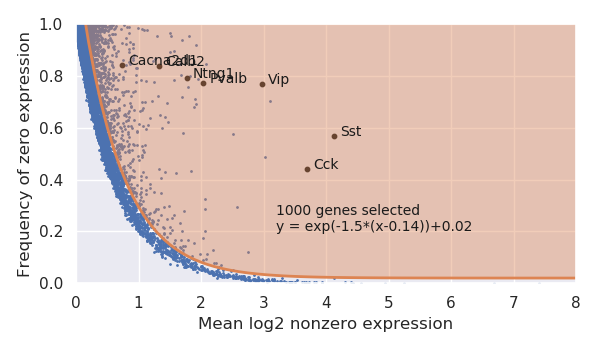

In [4]:
# Feature selection

importantGenes = rnaseqTools.geneSelection(
    harris['counts'], n=1000,
    genes = harris['genes'], 
    markers=['Sst', 'Pvalb', 'Cacna2d1', 'Calb2', 'Ntng1', 'Cck', 'Vip'])

# Library size normalization and log(x+1) transform

librarySizes = np.array(np.sum(harris['counts'], axis=1))
X = np.log2(harris['counts'][:, importantGenes] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)

# PCA

X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001

<IPython.core.display.Javascript object>


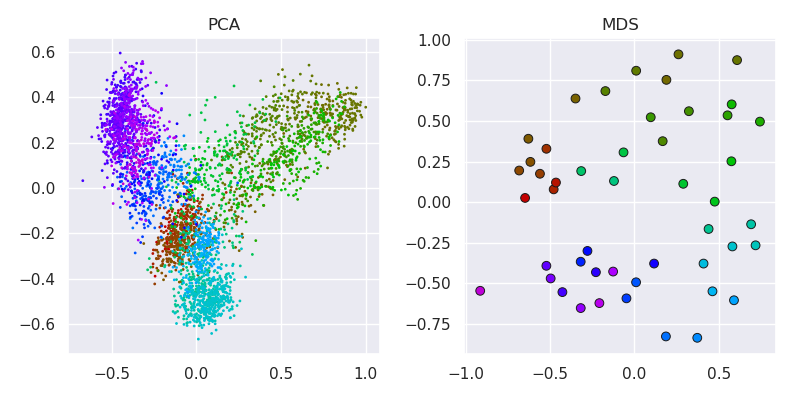

In [8]:
# PCA and MDS

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], s=1, c=harris['clusterColors'][harris['clusters']])
plt.title('PCA')

K = harris['clusterNames'].size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.mean(X[harris['clusters']==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)
cryabCluster = np.where(harris['clusterNames']=='Sst.Cryab')[0]
B[cryabCluster,:] = np.nan

plt.subplot(122)
plt.scatter(B[:,0], B[:,1], color=harris['clusterColors'],
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS')
plt.tight_layout()

<IPython.core.display.Javascript object>


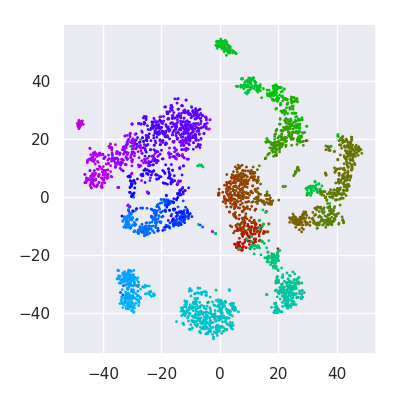

(0.4544362544362544, 0.7448979591836735, 0.56997340921917)
(0.4549003549003549, 0.7081632653061225, 0.4535854397571784)


In [9]:
# t-SNE

Z_harris_default = fast_tsne(X, perplexity=30, seed=42)
Z_harris = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)],
                     initialization=PCAinit, learning_rate = X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z_harris[:,0], Z_harris[:,1], s=1, c=harris['clusterColors'][harris['clusters']])
plt.tight_layout()

harris_quality = embedding_quality(X, Z_harris, harris['clusters'])
harris_quality_default = embedding_quality(X, Z_harris_default, harris['clusters'])

print(harris_quality)
print(harris_quality_default)

<IPython.core.display.Javascript object>


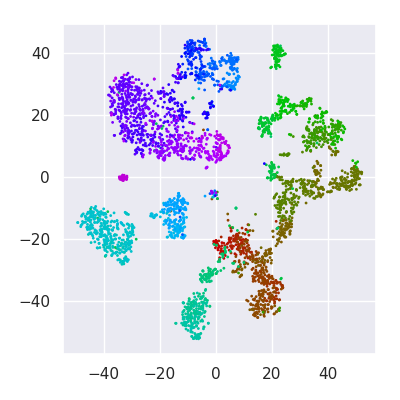

In [10]:
# What happens if we do standardization before PCA

X = np.log2(harris['counts'][:, importantGenes] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
X = X / X.std(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]
X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Z = fast_tsne(X, perplexity=30, initialization=PCAinit)

plt.figure(figsize=(4,4))
plt.scatter(Z[:,0], Z[:,1], s=1, c=harris['clusterColors'][harris['clusters']])
plt.tight_layout()

## Shekhar et al., Cell 2016

The data are taken from:
* `GSE81904_BipolarUMICounts_Cell2016.txt.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81904
* `clust_retinal_bipolar.txt` is from https://hemberg-lab.github.io/scRNA.seq.datasets/mouse/retina/

In [11]:
%%time

filename = '../data/shekhar-cell/GSE81904_BipolarUMICounts_Cell2016.txt.gz'
counts, genes, cells = rnaseqTools.sparseload(filename, sep='\t')

clusterData = pd.read_csv('../data/shekhar-cell/clust_retinal_bipolar.txt', sep='\t')

clusterNames, clusters = np.unique(clusterData.values[:,1], return_inverse=True)
clusterNames[clusterNames=='BC5A (Cone Bipolar cell 5A)'] = 'BC5A'
clusterNames[clusterNames=='BC7 (Cone Bipolar cell 7)'] = 'BC7'
clusterNames[clusterNames=='BC8/9 (mixture of BC8 and BC9)'] = 'BC8/9'
clusterNames[clusterNames=='AC (Amacrine cell)'] = 'Amacrine cells'
clusterNames[clusterNames=='Cone Photoreceptors'] = 'Cones'
clusterNames[clusterNames=='Rod Photoreceptors'] = 'Rods'
clusterNames[clusterNames=='MG (Mueller Glia)'] = 'Mueller Glia'
clusterNames[clusterNames=='RBC (Rod Bipolar cell)'] = 'RBC'

# Taken from Figure 1
clusterColors = ['#39dcd5', '#ffa302', '#fc8203', '#fd6301',
                 '#fa4101', '#fe1e00', '#fc0005', '#acd8e5',
                 '#92b6e6', '#566be9', '#759ae9', '#3747f4',
                 '#4458f2', '#0004f3', '#fafc0a', '#8d8d8d',
                 '#1afbfe', '#00ff00', '#fefd1a']
clusterColors = np.array(clusterColors)

goodcells = clusterData.values[:,0]
cell2cluster = dict(zip(goodcells, clusters))
ind = np.isin(cells, goodcells)
cells = cells[ind]
counts = counts[ind,:]
clusters = np.array([cell2cluster[c] for c in cells])

shekhar = {'counts': counts, 'genes': genes, 'clusters': clusters, 
           'clusterColors': clusterColors, 'clusterNames': clusterNames}

pickle.dump(shekhar, open('../data/shekhar-cell/shekhar.pickle', "wb"), protocol=4)

......................... done
CPU times: user 7min 54s, sys: 7.44 s, total: 8min 1s
Wall time: 8min


In [5]:
shekhar = pickle.load(open('../data/shekhar-cell/shekhar.pickle', "rb"))
print(shekhar['counts'].shape)

(27499, 24904)


Chosen offset: 0.21


<IPython.core.display.Javascript object>


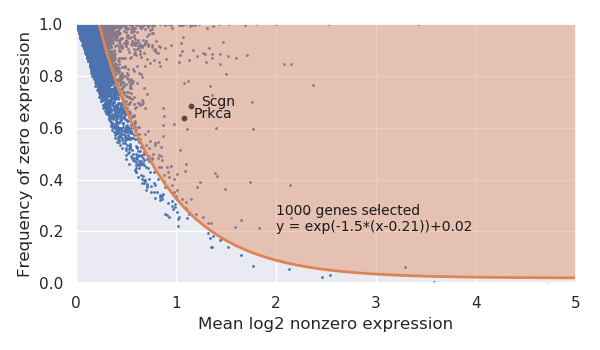

In [6]:
# Feature selection

importantGenes = rnaseqTools.geneSelection(
    shekhar['counts'], n=1000,
    genes = shekhar['genes'], markers=['Prkca', 'Scgn'])

# Library size normalization and log(x+1) transform

librarySizes = np.array(np.sum(shekhar['counts'], axis=1))
X = np.log2(shekhar['counts'][:, importantGenes] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)

# PCA (after standardizing)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001

<IPython.core.display.Javascript object>


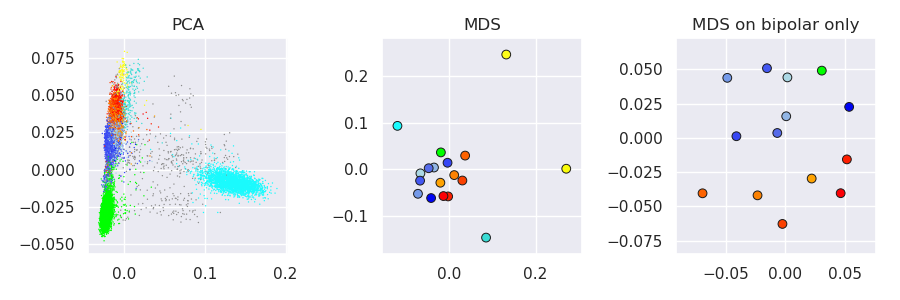

In [7]:
# PCA and MDS

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], s=1, c=shekhar['clusterColors'][shekhar['clusters']], 
            edgecolors='none')
plt.title('PCA')

K = shekhar['clusterNames'].size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.mean(X[shekhar['clusters']==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)
doubletClusterNum = np.where(shekhar['clusterNames'] == 'Doublets/Contaminants')[0]
B[doubletClusterNum, :] = np.nan

plt.subplot(132)
plt.scatter(B[:,0], B[:,1], color=shekhar['clusterColors'],
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS')
plt.tight_layout()

bcs = [i for i,c in enumerate(shekhar['clusterNames']) if c[:2]=='BC' or c[:2]=='RB']
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans[bcs,:])
plt.subplot(133)
plt.scatter(B[:,0], B[:,1], color=shekhar['clusterColors'][bcs],
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS on bipolar only')
plt.tight_layout()

<IPython.core.display.Javascript object>


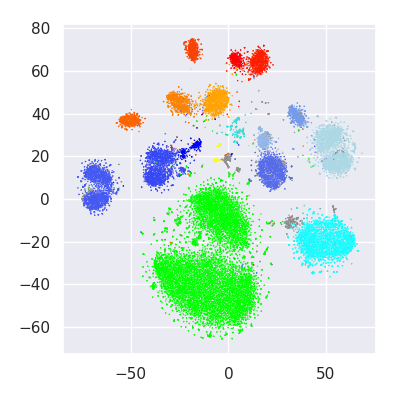

(0.2555729299247246, 0.6105263157894737, 0.4415260978340044)
(0.23832139350521836, 0.5736842105263158, 0.4192294446248999)


In [16]:
Z_shekhar_default = fast_tsne(X, perplexity=30, seed=42)

Z_shekhar = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)],
                      initialization=PCAinit, learning_rate=X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z_shekhar[:,0], Z_shekhar[:,1], s=1, c=shekhar['clusterColors'][shekhar['clusters']], 
            edgecolors='none')
plt.tight_layout()

shekhar_quality = embedding_quality(X, Z_shekhar, shekhar['clusters'])
shekhar_quality_default = embedding_quality(X, Z_shekhar_default, shekhar['clusters'])

print(shekhar_quality)
print(shekhar_quality_default)

<IPython.core.display.Javascript object>


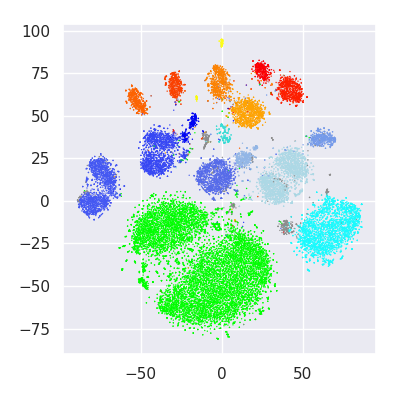

In [17]:
# What if we just use perplexity=30 here

Z = fast_tsne(X, perplexity=30, initialization=PCAinit, learning_rate=X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z[:,0], Z[:,1], s=1, c=shekhar['clusterColors'][shekhar['clusters']], 
            edgecolors='none')
plt.tight_layout()

<IPython.core.display.Javascript object>


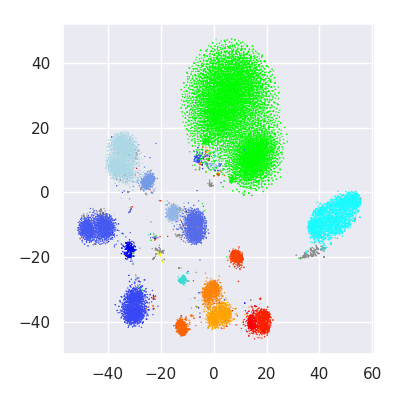

In [18]:
# Without standardizing

librarySizes = np.array(np.sum(shekhar['counts'], axis=1))
X = np.log2(shekhar['counts'][:, importantGenes] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)

X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001

Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)],
                      initialization=PCAinit, learning_rate=X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z[:,0], Z[:,1], s=1, c=shekhar['clusterColors'][shekhar['clusters']], edgecolors='none')
plt.tight_layout()

Chosen offset: 0.04
CPU times: user 3min 28s, sys: 240 ms, total: 3min 28s
Wall time: 52.3 s


<IPython.core.display.Javascript object>


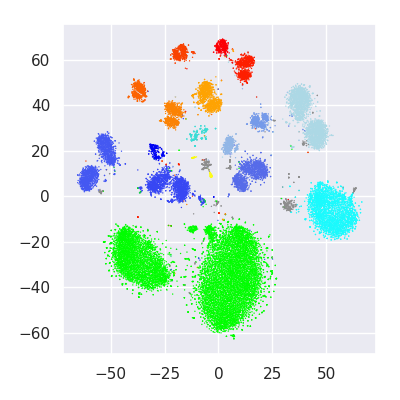

CPU times: user 3min 44s, sys: 5.03 s, total: 3min 49s
Wall time: 3min 4s


In [19]:
%%time

# USING 10k GENES - this is close to the pre-processing pipeline in the paper
# Produces much stronger batch effect

imp10k = rnaseqTools.geneSelection(shekhar['counts'], n=10000, plot=False)

librarySizes = np.array(np.sum(shekhar['counts'], axis=1))
X = np.log2(shekhar['counts'][:, imp10k] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)
%time U,s,V = scipy.sparse.linalg.svds(X, k=50)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]]

PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)],
              initialization=PCAinit, learning_rate=X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z[:,0], Z[:,1], s=1, c=shekhar['clusterColors'][shekhar['clusters']], edgecolors='none')
plt.tight_layout()

## Macosko et al. 2015

The data are taken from:

* `GSE63472_P14Retina_merged_digital_expression.txt.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63472
* `retina_clusteridentities.txt` is from http://mccarrolllab.org/wp-content/uploads/2015/05/retina_clusteridentities.txt

In [20]:
%%time

filename = '../data/makosco-cell/GSE63472_P14Retina_merged_digital_expression.txt.gz'
counts, genes, cells = rnaseqTools.sparseload(filename, sep='\t')
genes = np.array([g[0]+g[1:].lower() for g in genes])

data = pd.read_csv('../data/makosco-cell/retina_clusteridentities.txt', sep='\t', header=None)
cell2cluster = dict(data.values)
goodcells = np.array(data.values[:,0])

ind = np.isin(cells, goodcells)
cells = cells[ind]
counts = counts[ind,:]

clusterNames = ['Horizontal cells', 'Ganglion cells']
for c in range(3,24):
    clusterNames.append(str(c))
clusterNames.extend(('Rods', 'Cones'))
for c in range(26,34):
    clusterNames.append(str(c))
clusterNames.extend(('Mueller glia', 'Astrocytes', 'Fibroblasts', 
                     'Endothelium', 'Pericytes', 'Microglia'))
clusterNames = np.array(clusterNames)

clusterColors = ['#b33b19', '#c38a1f'] + ['#9ac222']*21 + ['#538cba']*2 + \
                ['#2000d7']*8 + ['#8b006b']*6
clusterColors = np.array(clusterColors)

clusters = np.array([cell2cluster[c] for c in cells]) - 1

macosko = {'counts': counts, 'genes': genes, 'clusters': clusters,
           'clusterColors': clusterColors, 'clusterNames': clusterNames}

pickle.dump(macosko, open('../data/makosco-cell/macosko.pickle', "wb"))

......................... done
CPU times: user 8min 55s, sys: 7.94 s, total: 9min 3s
Wall time: 9min 2s


In [21]:
macosko = pickle.load(open('../data/makosco-cell/macosko.pickle', "rb"))
print(macosko['counts'].shape)

(44808, 24658)


Chosen offset: 0.19


<IPython.core.display.Javascript object>


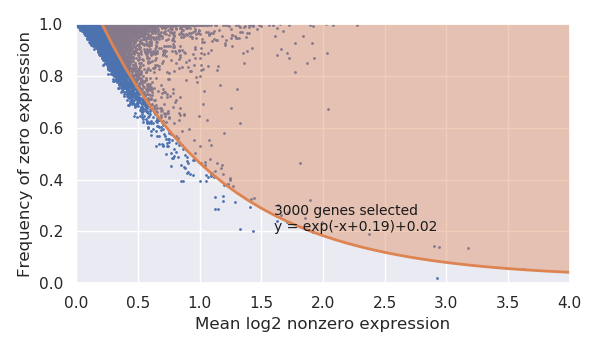

In [22]:
# Weird things about Macosko data:

# 0) Decay=1 and overall strange QC -- huge amount of zeros?
# 1) Using 1000 genes produces strange embedding with a lot of rod miniclusters
# 2) Not standardizing genes loses A LOT of detail (e.g. all BC types merge)
# 3) Normalizing to 1e+6 yields very strong artifact shapes (e.g. heart shape)

importantGenes = rnaseqTools.geneSelection(macosko['counts'], n=3000, decay=1)

librarySizes = np.array(np.sum(macosko['counts'], axis=1))
X = np.log2(macosko['counts'][:, importantGenes] / librarySizes * np.median(librarySizes) + 1)  
X = np.array(X)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001

<IPython.core.display.Javascript object>


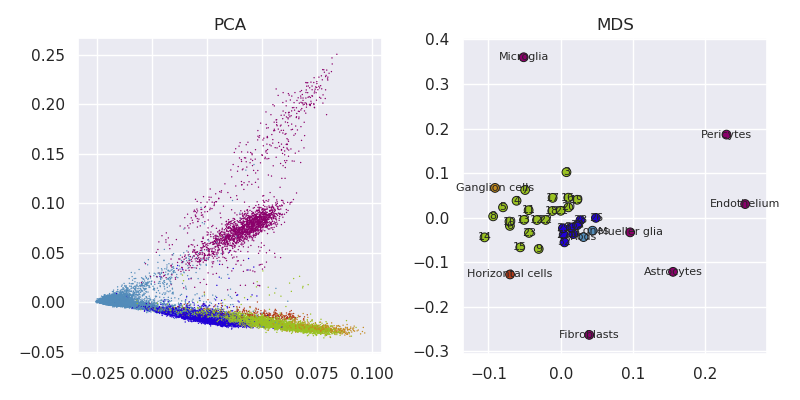

In [24]:
# PCA and MDS

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], s=1, edgecolor='none', c=macosko['clusterColors'][macosko['clusters']])
plt.title('PCA')

K = macosko['clusterNames'].size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.mean(X[macosko['clusters']==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)

plt.subplot(122)
plt.scatter(B[:,0], B[:,1], color=macosko['clusterColors'],
            s=40, edgecolor='k', linewidth=.7);
for i,t in enumerate(macosko['clusterNames']):
    plt.text(B[i,0], B[i,1], t, ha='center', va='center', fontsize=8)
plt.title('MDS')
plt.tight_layout()

CPU times: user 684 ms, sys: 72 ms, total: 756 ms
Wall time: 40.9 s
CPU times: user 660 ms, sys: 52 ms, total: 712 ms
Wall time: 5min 11s


<IPython.core.display.Javascript object>


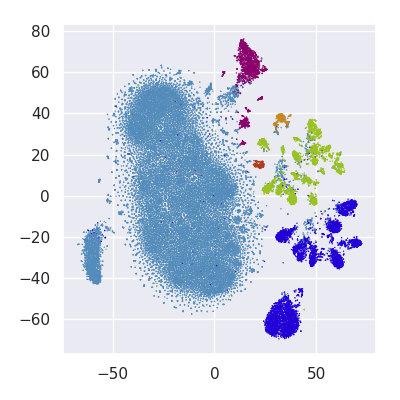

In [25]:
%time Z_macosko_default = fast_tsne(X, perplexity=30, seed=42)

%time Z_macosko = fast_tsne(X, perplexity_list=[30, int(X.shape[0]/100)], initialization=PCAinit, learning_rate=X.shape[0]/12)

plt.figure(figsize=(4,4))
plt.scatter(Z_macosko[:,0], Z_macosko[:,1], s=1, edgecolor='none', 
            c=macosko['clusterColors'][macosko['clusters']])
plt.tight_layout()

In [ ]:
# SUPER SLOW!

%time macosko_quality = embedding_quality(X, Z_macosko, macosko['clusters'])
%time macosko_quality_default = embedding_quality(X, Z_macosko_default, macosko['clusters'])

print(macosko_quality)
print(macosko_quality_default)

## Combined figure

<IPython.core.display.Javascript object>


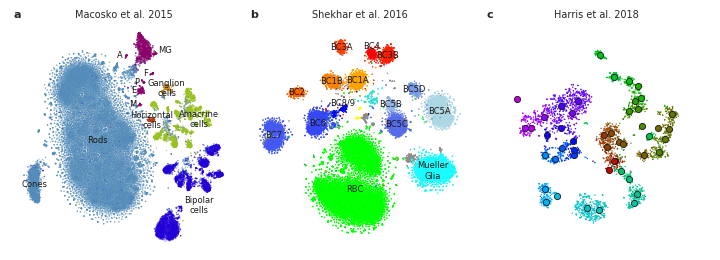

In [29]:
sns_styleset()

plt.figure(figsize=(7.2, 2.6))
plt.subplot(131)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_macosko[:,0], Z_macosko[:,1], s=1, edgecolor='none', 
            c=macosko['clusterColors'][macosko['clusters']], alpha=.5,
            rasterized=True)
plt.title('Macosko et al. 2015')
plt.xticks([])
plt.yticks([])
nonNumberedClusters = np.array([i for i,c in enumerate(macosko['clusterNames']) if len(c)>2])
renames = {'Mueller glia': 'MG', 'Astrocytes': 'A', 'Fibroblasts': 'F',
 'Endothelium': 'E', 'Pericytes': 'P', 'Microglia': 'M'}
for cl in nonNumberedClusters:
    mu = np.median(Z_macosko[macosko['clusters']==cl], axis=0)
    if macosko['clusterNames'][cl] in renames:
        label = renames[macosko['clusterNames'][cl]]
        if label != 'MG':
            dx = -5
        else:
            dx = 15
    else:
        label = '\n'.join(macosko['clusterNames'][cl].split())
        dx = 0
    plt.text(mu[0]+dx, mu[1], label, color='k', 
                 fontsize=6, ha='center', va='center')
plt.text(55, 10, 'Amacrine\ncells', color='k', fontsize=6, ha='center') 
plt.text(55, -50, 'Bipolar\ncells', color='k', fontsize=6, ha='center') 

plt.subplot(132)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_shekhar[:,0], Z_shekhar[:,1], s=1, edgecolor='none', 
            c=shekhar['clusterColors'][shekhar['clusters']], rasterized=True)
plt.title('Shekhar et al. 2016')
plt.xticks([])
plt.yticks([])
for cl in range(np.max(shekhar['clusters'])+1):
    mu = np.median(Z_shekhar[shekhar['clusters']==cl], axis=0)
    dy = 0
    if shekhar['clusterNames'][cl] in ['BC4', 'BC8/9']:
        dy = 5
    if shekhar['clusterNames'][cl] not in ['Doublets/Contaminants', 'Cones', 'Rods', 'Amacrine cells']:
        plt.text(mu[0], mu[1]+dy, '\n'.join(shekhar['clusterNames'][cl].split()), color='k', 
                 fontsize=6, ha='center', va='center')

plt.subplot(133)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z_harris[:,0], Z_harris[:,1], s=1, edgecolor='none', 
            c=harris['clusterColors'][harris['clusters']])
plt.title('Harris et al. 2018')
plt.xticks([])
plt.yticks([])
for cl in range(np.max(harris['clusters'])+1):
    mu = np.median(Z_harris[harris['clusters']==cl], axis=0)
    if harris['clusterNames'][cl] != 'Sst.Cryab':
        plt.scatter(mu[0], mu[1], s=20, color=harris['clusterColors'][cl],
                    edgecolor='k', linewidth=.6)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.text(0, 1.04, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.04, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.04, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')

plt.savefig('figures/umis.png', dpi=150)
plt.savefig('figures/umis.pdf', dpi=300)
plt.savefig('figures/umis-600.pdf', dpi=600)

<IPython.core.display.Javascript object>


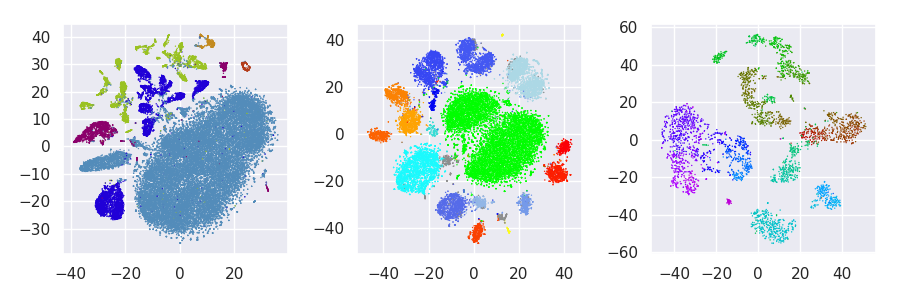

In [26]:
sns.set()
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.scatter(Z_macosko_default[:,0], Z_macosko_default[:,1], s=1, edgecolor='none', 
            c=macosko['clusterColors'][macosko['clusters']])
plt.subplot(132)
plt.scatter(Z_shekhar_default[:,0], Z_shekhar_default[:,1], s=1, edgecolor='none', 
            c=shekhar['clusterColors'][shekhar['clusters']])
plt.subplot(133)
plt.scatter(Z_harris_default[:,0], Z_harris_default[:,1], s=1, edgecolor='none', 
            c=harris['clusterColors'][harris['clusters']])

plt.tight_layout()

## Shekhar/Macosko correspondence

In [30]:
importantGenes = rnaseqTools.geneSelection(shekhar['counts'], n=1000, decay=1.5, plot=False)
bipolar = np.isin(macosko['clusterNames'][macosko['clusters']], 
                  ['26','27','28','29','30','31','32','33'])

pos = np.zeros((macosko['counts'].shape[0], 2))
pos[bipolar,:] = rnaseqTools.map_to_tsne(shekhar['counts'][:,importantGenes], shekhar['genes'][importantGenes],
                                         macosko['counts'][bipolar,:], macosko['genes'], Z_shekhar)

Chosen offset: 0.21
Using a common set of 936 genes.
Processing in batches....... done


<IPython.core.display.Javascript object>


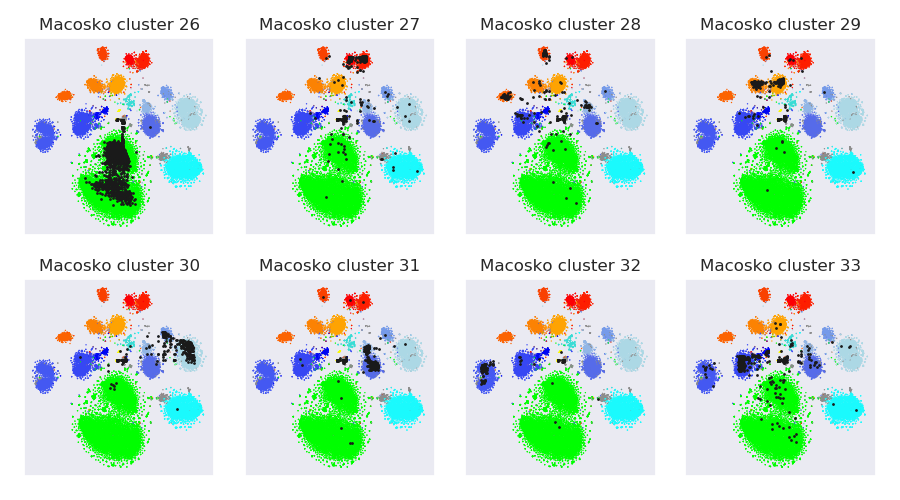

In [32]:
sns.set()
plt.figure(figsize=(9,5))
for cl in range(26,33+1):
    plt.subplot(2,4,cl-25)
    plt.scatter(Z_shekhar[:,0], Z_shekhar[:,1], s=1, edgecolor='none',
                c=shekhar['clusterColors'][shekhar['clusters']])
    plt.title('Macosko cluster ' + str(cl))
    plt.scatter(pos[macosko['clusters']==cl-1,0], pos[macosko['clusters']==cl-1,1], 
                color='k', s=1)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()